In [23]:
# preprocess the real data from Elham lab and peprform the archetype analysis
import copy
import importlib
import os
import re
import sys
import os
import scipy.sparse as sp

parent_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_folder)
import anndata
import numpy as np

import pandas as pd
import scanpy as sc

from sklearn.metrics import silhouette_score

import scvi
import seaborn as sns
from anndata import AnnData
from matplotlib import pyplot as plt
from py_pcha import PCHA
from scipy.sparse import issparse
from scipy.spatial.distance import cdist
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sympy.physics.units import current
from tqdm import tqdm
from kneed import KneeLocator

import bar_nick_utils
import covet_utils

importlib.reload(bar_nick_utils)
importlib.reload(covet_utils)
from covet_utils import compute_covet

from bar_nick_utils import preprocess_rna, preprocess_protein, plot_archetypes, \
    get_cell_representations_as_archetypes_cvxpy, reorder_rows_to_maximize_diagonal, evaluate_distance_metrics, \
    plot_archetypes_matching, compare_matchings, find_best_pair_by_row_matching, add_spatial_data_to_prot, \
    clean_uns_for_h5ad, get_latest_file

plot_flag = True
# computationally figure out which ones are best
np.random.seed(8)
! which python



/opt/conda/envs/scvi/bin/python


In [24]:
### reading in data

/home/barroz/.local/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


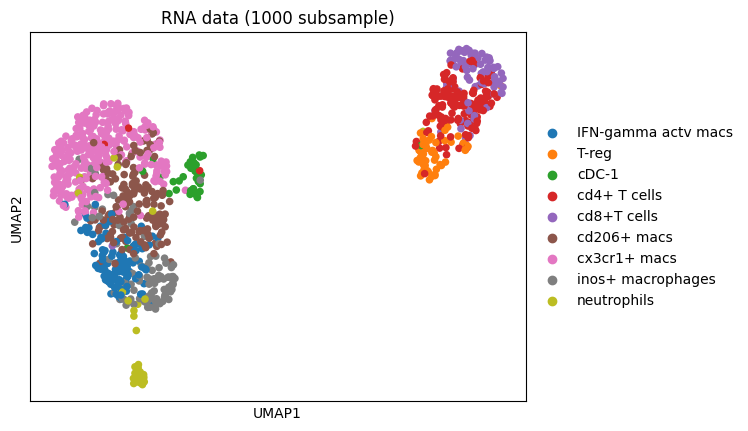

/home/barroz/.local/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


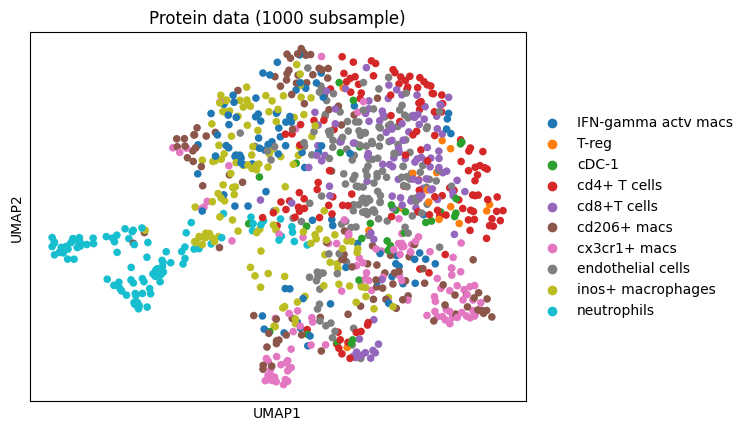

In [25]:

adata_1 = sc.read("../rna_umap.h5ad") # 5546 × 13447 
adata_2 = sc.read("../codex_cn_tumor.h5ad") # 893987 × 30

# filter out all tumor type cells
adata_2 = adata_2[adata_2.obs['cell_type'] != 'tumor']
adata_2 = adata_2[adata_2.obs['cell_type'] != 'dead']

num_rna_cells = 6000
num_protein_cells = 20000
# num_rna_cells = num_protein_cells= 1000
subsample_n_obs_rna = min(adata_1.shape[0],num_rna_cells)
subsample_n_obs_protein = min(adata_2.shape[0],num_protein_cells)
sc.pp.subsample(adata_1, n_obs=subsample_n_obs_rna)
sc.pp.subsample(adata_2, n_obs=subsample_n_obs_protein)

adata_1.obs['cell_types'] = adata_1.obs['new_annotation']
adata_2.obs['cell_types'] = adata_2.obs['cell_type']

# nk cells seems to mess up the archetype matching, for now remove them
adata_1 = adata_1[adata_1.obs['cell_types'] != 'nk cells'] 
adata_2 = adata_2[adata_2.obs['cell_types'] != 'nk cells']


adata_1 = adata_1[adata_1.obs['cell_types'].argsort(), :]  # sort by cell types for easier visualization
# adata_2 = adata_2[adata_2.obs['cell_types'].argsort(), :]  # sort by cell types for easier visualization
adata_2 = adata_2[adata_2.obs['cell_types'].argsort(), :]  # sort by cell types for easier visualization

# initial_adata_rna = adata[adata.obs['batch'] == f'SLN111-D1']
# initial_adata_protein = adata[adata.obs['batch'] == f'SLN208-D1'] 
# get rna from one patient, protein from the other then run the whole archetype analysis
# cell type protein, cell type rna, see which one's 
# plot data before preprocessing with a subsample of 1000 cells
if plot_flag:
    subsample_n_obs_rna_plot = min(adata_1.shape[0], 1000)
    subsample_n_obs_protein_plot = min(adata_2.shape[0], 1000)
    
    adata_1_plot = adata_1[np.random.choice(adata_1.shape[0], subsample_n_obs_rna_plot, replace=False), :]
    adata_2_plot = adata_2[np.random.choice(adata_2.shape[0], subsample_n_obs_protein_plot, replace=False), :]
    
    # same for RNA
    sc.pp.pca(adata_1_plot, n_comps=10)
    sc.pp.neighbors(adata_1_plot)  # Compute the neighbors needed for UMAP
    sc.tl.umap(adata_1_plot)  # Calculate UMAP coordinates
    sc.pl.umap(adata_1_plot, color='cell_types', title='RNA data (1000 subsample)')
    
    # same for Protein
    sc.pp.pca(adata_2_plot, n_comps=10)
    sc.pp.neighbors(adata_2_plot)  # Compute the neighbors needed for UMAP
    sc.tl.umap(adata_2_plot)  # Calculate UMAP coordinates
    sc.pl.umap(adata_2_plot, color='cell_types', title='Protein data (1000 subsample)')

    

In [26]:
# make sure we dont have gene column in var if it is equal to the index
if 'gene' in adata_1.var.columns and np.array_equal(adata_1.var['gene'].values, (adata_1.var.index.values)):
    adata_1.var.drop(columns='gene', inplace=True)
if 'gene' in adata_2.var.columns and np.array_equal(adata_2.var['gene'].values, (adata_2.var.index.values)):
    adata_2.var.drop(columns='gene', inplace=True)

In [27]:
set(adata_1.obs['new_annotation']), set(adata_2.obs['cell_type'])

({'IFN-gamma actv macs',
  'T-reg',
  'cDC-1',
  'cd206+ macs',
  'cd4+ T cells',
  'cd8+T cells',
  'cx3cr1+ macs',
  'inos+ macrophages',
  'neutrophils'},
 {'IFN-gamma actv macs',
  'T-reg',
  'cDC-1',
  'cd206+ macs',
  'cd4+ T cells',
  'cd8+T cells',
  'cx3cr1+ macs',
  'endothelial cells',
  'inos+ macrophages',
  'neutrophils'})

In [28]:
# filer out the cell types that are not in the other dataset
mutual_cell_types = set(adata_1.obs['new_annotation']).intersection(set(adata_2.obs['cell_type']))
adata_1 = adata_1[adata_1.obs['new_annotation'].isin(mutual_cell_types)]
adata_2 = adata_2[adata_2.obs['cell_type'].isin(mutual_cell_types)]
adata_1.obs['major_cell_types'] = adata_1.obs['new_annotation'].values
adata_2.obs['major_cell_types'] = adata_2.obs['cell_type'].values

/var/tmp/ipykernel_32646/506856982.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_1.obs['major_cell_types'] = adata_1.obs['new_annotation'].values
/var/tmp/ipykernel_32646/506856982.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_2.obs['major_cell_types'] = adata_2.obs['cell_type'].values


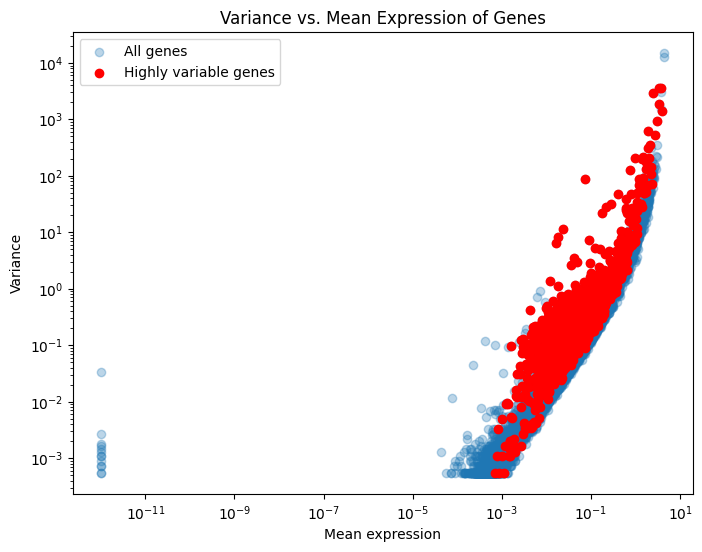

In [29]:

# Scatter plot of variance vs. mean expression
# common approach to inspect the variance of genes. It shows the relationship between mean expression and variance (or dispersion) and highlights the selected highly variable genes.
if plot_flag:
    sc.pp.highly_variable_genes(adata_1, n_top_genes=2000)
    plt.figure(figsize=(8, 6))
    plt.scatter(adata_1.var['means'], adata_1.var['variances'], alpha=0.3, label='All genes')
    plt.scatter(adata_1.var['means'][adata_1.var['highly_variable']],
                adata_1.var['variances'][adata_1.var['highly_variable']],
                color='red', label='Highly variable genes')
    plt.xlabel('Mean expression')
    plt.ylabel('Variance')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.title('Variance vs. Mean Expression of Genes')
    plt.show()

In [30]:
# plt.figure(figsize=(8, 6))
# plt.hist(adata_1.var['variances'], bins=75, alpha=0.7)
# plt.axvline(x=adata_1.var['variances'][adata_1.var['highly_variable']].min(), color='red', linestyle='dashed', label='Cutoff')
# plt.xlabel('Variance')
# plt.ylabel('Frequency')
# plt.yscale('log')
# plt.title('Distribution of Gene Variances')
# plt.legend()
# plt.show()

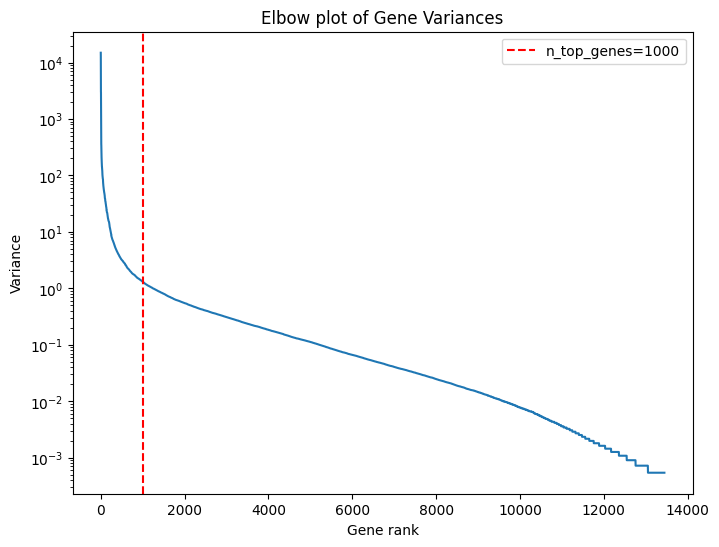

<Figure size 640x480 with 0 Axes>

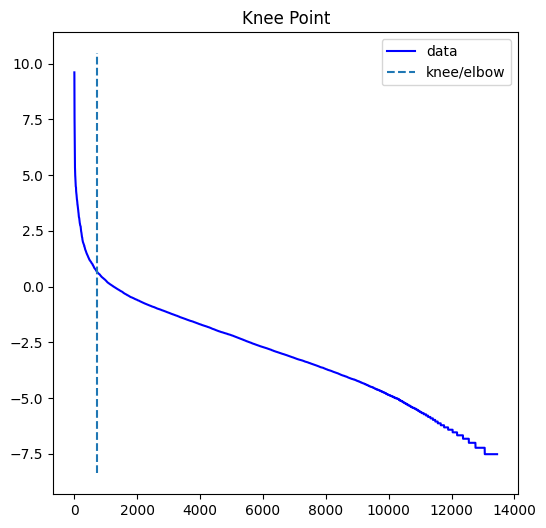

In [31]:
variances_sorted = np.sort(adata_1.var['variances'])[::-1]

if plot_flag:
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(variances_sorted) + 1), variances_sorted)
    plt.xlabel('Gene rank')
    plt.ylabel('Variance')
    # plt.xscale('log')

    plt.yscale('log')
    plt.title('Elbow plot of Gene Variances')
    plt.axvline(x=1000, color='red', linestyle='dashed', label='n_top_genes=1000')
    plt.legend()
    plt.show()
    plt.figure()
kneedle = KneeLocator(range(1, len(variances_sorted) + 1), np.log(variances_sorted), S=4.0, curve="convex",
                      direction="decreasing")
if plot_flag:
    kneedle.plot_knee()


In [32]:
adata_1 = preprocess_rna(adata_1,n_top_genes=kneedle.knee)


/home/barroz/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Selected 713 highly variable genes.


/home/barroz/.local/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Variance ratio after highly variable gene selection PCA (10 PCs): 0.5504
Variance ratio after log transformation PCA (10 PCs): 0.5504
Variance ratio after normalization PCA (10 PCs): 0.5159


In [33]:
adata_1 = adata_1[
    adata_1.obs.sort_values(by=['cell_types']).index
]

In [34]:

adata_1_rna = adata_1.copy()
sc.pp.pca(adata_1_rna)
print(f'variance explained by first 10 PCs {adata_1_rna.uns["pca"]["variance_ratio"][:10].sum()}')
adata_1_rna = preprocess_rna(adata_1_rna)
sc.pp.pca(adata_1_rna)

variance explained by first 10 PCs 0.5159093405748042
Selected 586 highly variable genes.


/home/barroz/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Variance ratio after highly variable gene selection PCA (10 PCs): 0.5657


/home/barroz/.local/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Variance ratio after log transformation PCA (10 PCs): 0.3944
Variance ratio after normalization PCA (10 PCs): 0.3998


In [35]:
adata_1_rna

AnnData object with n_obs × n_vars = 1939 × 586
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tSNE_1', 'tSNE_2', 'Sample', 'Cluster', 'nUmi', 'nGene', 'nUmiLog2', 'nGeneLog2', 'new_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden', 'cell_types', 'major_cell_types', 'n_genes'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm'
    uns: 'Cluster_colors', 'Sample_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'new_annotation_colors', 'pca'

In [36]:
# adata_1_rna.obsm.pop('protein_expression')
# assert len(set(adata.obs['batch']))!=1
adata_2_prot = preprocess_protein(adata_2)
# # add all obs and var to adata_prot
# adata_prot.obs = adata_rna.obs (this is a potential problem as rna and protein obs don't match currently)


Variance ratio after PCA (10 PCs): 0.8327
Variance ratio after normalization PCA (10 PCs): 0.7247
Variance ratio after scaling PCA (10 PCs): 0.7247


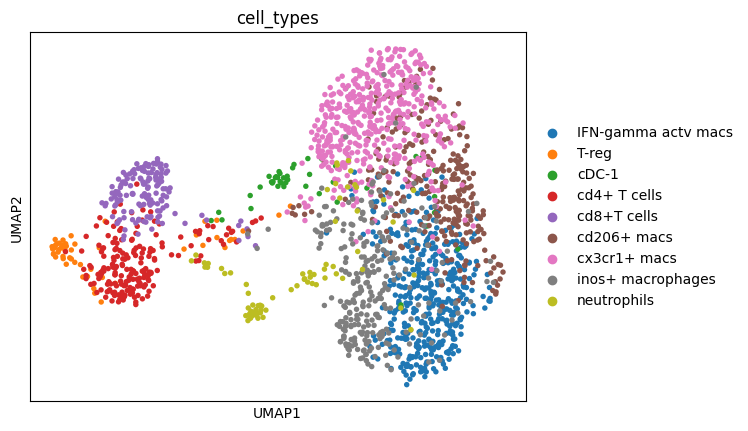

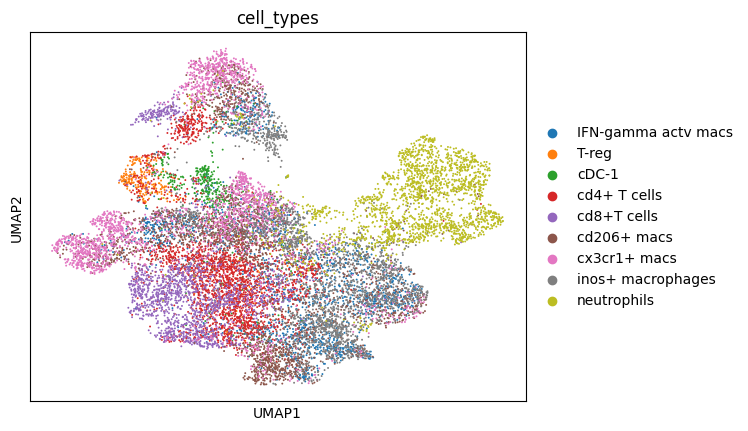

In [37]:
if plot_flag:
    # same for rna
    sc.pp.pca(adata_1_rna)
    sc.pp.neighbors(adata_1_rna)  # Compute the neighbors needed for UMAP
    sc.tl.umap(adata_1_rna)  # Calculate UMAP coordinates
    sc.pl.umap(adata_1_rna, color='cell_types')
    # same for protein
    sc.pp.pca(adata_2_prot)
    sc.pp.neighbors(adata_2_prot)  # Compute the neighbors needed for UMAP
    sc.tl.umap(adata_2_prot)  # Calculate UMAP coordinates
    sc.pl.umap(adata_2_prot, color='cell_types')


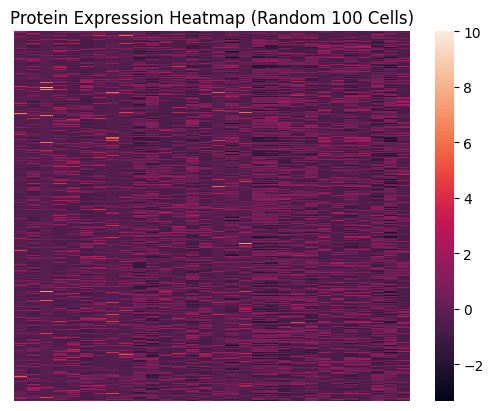

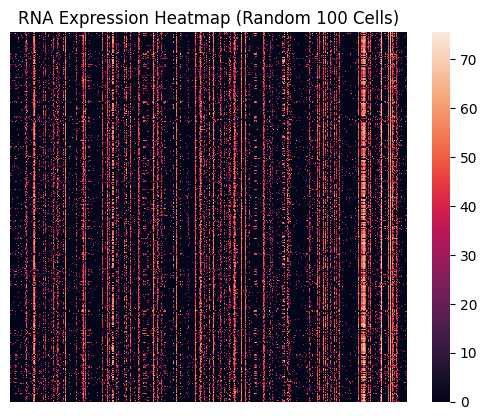

In [38]:
# Randomly select 100 cells
num_cells = min(1000, adata_1_rna.n_obs, adata_2_prot.n_obs)
random_indices_protein = np.random.choice(adata_2_prot.n_obs, num_cells, replace=False)
random_indices_rna = np.random.choice(adata_1_rna.n_obs, num_cells, replace=False)

# For protein data
protein_data = adata_2_prot.X[random_indices_protein, :]
sns.heatmap(protein_data, xticklabels=False, yticklabels=False)
plt.title("Protein Expression Heatmap (Random 100 Cells)")
plt.show()

# For RNA data
rna_data = adata_1_rna.X[random_indices_rna, :].todense() if issparse(adata_1_rna.X) else adata_1_rna.X[random_indices_rna, :]
sns.heatmap(rna_data, xticklabels=False, yticklabels=False)
plt.title("RNA Expression Heatmap (Random 100 Cells)")
plt.show()

In [39]:
adata_2_prot.obs = adata_2_prot.obs.drop(columns=['n_genes'])
adata_2_prot.obsm.pop('X_pca')
adata_2_prot.varm.pop('PCs')
original_protein_num = adata_2_prot.X.shape[1]

In [40]:
adata_2_prot.obs['major_cell_types'].unique()
adata_2_prot.obs['cell_types'].unique()

['IFN-gamma actv macs', 'T-reg', 'cDC-1', 'cd4+ T cells', 'cd8+T cells', 'cd206+ macs', 'cx3cr1+ macs', 'inos+ macrophages', 'neutrophils']
Categories (9, object): ['IFN-gamma actv macs', 'T-reg', 'cDC-1', 'cd4+ T cells', ..., 'cd206+ macs', 'cx3cr1+ macs', 'inos+ macrophages', 'neutrophils']

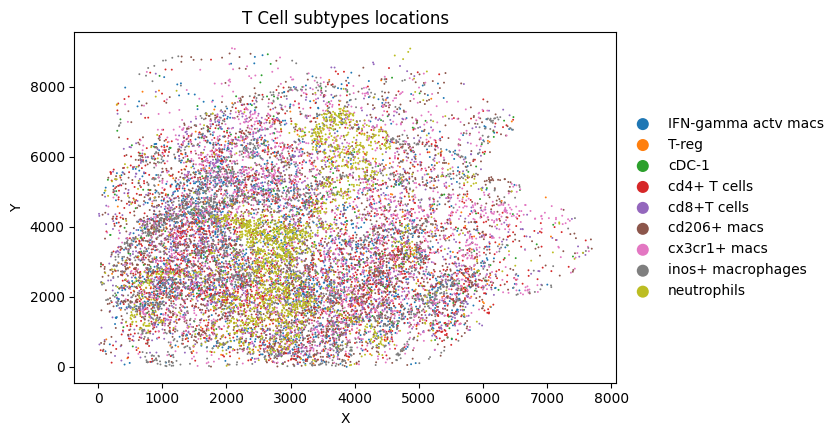

In [41]:

assert adata_2_prot.obs.index.is_unique
x_coor = adata_2_prot.obsm['spatial'][:, 0]
y_coor = adata_2_prot.obsm['spatial'][:, 1]
temp = pd.DataFrame([x_coor, y_coor], index=['x', 'y']).T
temp.index = adata_2_prot.obs.index
adata_2_prot.obsm['spatial_location'] = temp
adata_2_prot.obs['X'] = x_coor
adata_2_prot.obs['Y'] = y_coor
if plot_flag:
    sc.pl.scatter(adata_2_prot, x='X', y='Y', color='cell_types', title='T Cell subtypes locations')
    # sc.pl.scatter(adata_2_prot[adata_2_prot.obs['major_cell_types']=='CD8 T'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')

In [42]:
adata_2 = adata_2[
    adata_2.obs.sort_values(by=['cell_types']).index
]


In [43]:
clean_uns_for_h5ad(adata_2_prot)
clean_uns_for_h5ad(adata_1_rna)
time_stamp = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")
adata_1_rna.write(f'data/preprocessed_adata_rna_{time_stamp}.h5ad')
adata_2_prot.write(f'data/preprocessed_adata_prot_{time_stamp}.h5ad')
